# Tutorial3: GAT implementation

## Outline

- Implementation of GAT

Official resources:
* [Code](https://dsgiitr.com/blogs/gat/)

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 78.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 110.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.3 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-4lippvy0
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-4lippvy0
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 5d81cab11c4a29b8975abd46440f3e85c64dc0d4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-an

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Structure

In [3]:
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """
    def __init__(self):
        super(GATLayer, self).__init__()

    def forward(self, input, adj):
        print("")

## Let's start from the forward method

### Linear Transformation

$$
\bar{h'}_i = \textbf{W}\cdot \bar{h}_i
$$
with $\textbf{W}\in\mathbb R^{F'\times F}$ and $\bar{h}_i\in\mathbb R^{F}$.

$$
\bar{h'}_i \in \mathbb{R}^{F'}
$$

In [7]:
in_features = 5 # Node feature set size
out_features = 2 # Output size of node feature representation learning
nb_nodes = 3 # No. of nodes in graph
W = nn.Parameter(torch.zeros(size=(in_features, out_features))) # Learnable parameter W initializtion with zero value
print("Value of W:\n")
nn.init.xavier_uniform_(W.data, gain=1.414) #xavier paramiter inizializator for W as it is used in research paper

Value of W:



tensor([[ 0.4392,  0.6590],
        [ 1.1662, -0.9990],
        [ 0.6655,  0.9557],
        [-0.7284,  0.8615],
        [-1.2892,  0.4005]])

In [5]:
h_i = torch.rand(nb_nodes,in_features)
print('Node featurset in ith iteration:\n',h_i)

Node featurset in ith iteration:
 tensor([[0.2602, 0.8676, 0.9612, 0.2452, 0.6607],
        [0.8238, 0.8518, 0.8784, 0.8046, 0.6991],
        [0.0051, 0.0881, 0.8863, 0.1439, 0.6003]])


In [6]:
# linear transformation of Input vector h_i
h_i_prime = torch.mm(h_i, W) # Matrix dot multiplication
N = h_i_prime.size()[0] # No. of nodes
print("shape of Node featureset vectore before  Linear transformation:",h_i.shape)
print("Shape of W vectore:",W.size())
print("shape of output vectore after Linear transformation:\n[",h_i.shape,'] DOT [',W.size(),'] =',h_i_prime.shape)
print("\nValue of Node feature after Linear transformation:\n",h_i_prime)

shape of Node featureset vectore before  Linear transformation: torch.Size([3, 5])
Shape of W vectore: torch.Size([5, 2])
shape of output vectore after Linear transformation:
[ torch.Size([3, 5]) ] DOT [ torch.Size([5, 2]) ] = torch.Size([3, 2])

Value of Node feature after Linear transformation:
 tensor([[2.9448, 0.9247],
        [3.9400, 0.3905],
        [1.9679, 1.0365]], grad_fn=<MmBackward0>)


### Attention Mechanism

![title](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/AttentionMechanism.png?raw=1)

In [8]:
a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) #Learnable attention prameter initialization
nn.init.xavier_uniform_(a.data, gain=1.414) #xavier paramiter inizializator for attention
print("Shape of Attention parameter:",a.shape)
print("Attnetion parameter value:\n",a.data)
leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU function initialization

Shape of Attention parameter: torch.Size([4, 1])
Attnetion parameter value:
 tensor([[ 1.0718],
        [ 0.7596],
        [-0.1181],
        [ 1.2455]])


**Concatinate Wh_i and Wh_j**
In our example we have take 3 node and making all possible combination of these node features


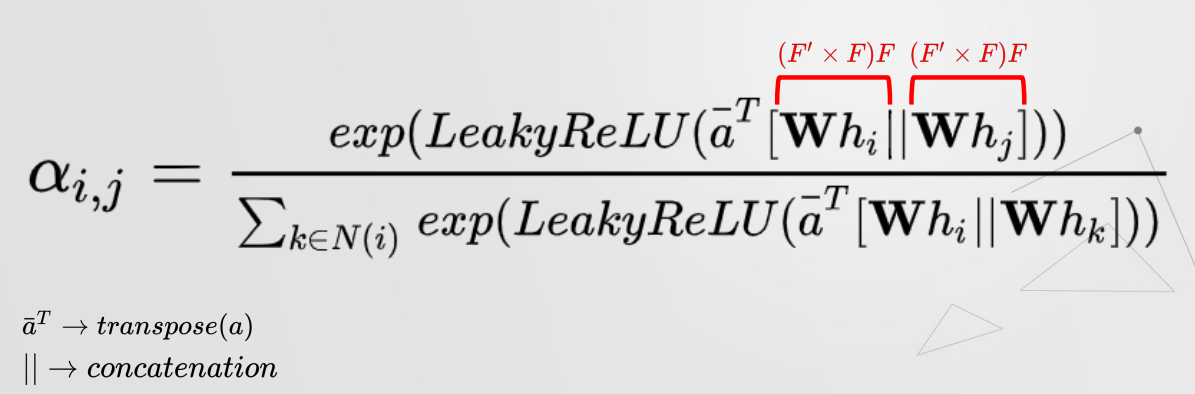

In [9]:
# Tensor.repeat - alogn the given dimention tendor data repeated e.g h.repeat(2,3,4) means exapn 4 time alogn column, 3 times alogin row and alogn z-dim expan 2 times, view is like reshape for given tensor
# Tensor.cat is concatination of tensor alogin given dim. dim=0 means alogn row, dim=1 mean alogn col
h_i_prime_concatination = torch.cat([h_i_prime.repeat(1, N).view(N * N, -1), h_i_prime.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features)
print("Node feature concatination after LT:\n",h_i_prime_concatination)

Node feature concatination after LT:
 tensor([[[2.9448, 0.9247, 2.9448, 0.9247],
         [2.9448, 0.9247, 3.9400, 0.3905],
         [2.9448, 0.9247, 1.9679, 1.0365]],

        [[3.9400, 0.3905, 2.9448, 0.9247],
         [3.9400, 0.3905, 3.9400, 0.3905],
         [3.9400, 0.3905, 1.9679, 1.0365]],

        [[1.9679, 1.0365, 2.9448, 0.9247],
         [1.9679, 1.0365, 3.9400, 0.3905],
         [1.9679, 1.0365, 1.9679, 1.0365]]], grad_fn=<ViewBackward0>)


![title](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/a_input.png?raw=1)

In [10]:
# Mutiliply attention and Concatinated value:
Mul = torch.matmul(h_i_prime_concatination, a)
print("Linear summation of Input with attention weights as per NN summation function:\n",Mul)

Linear summation of Input with attention weights as per NN summation function:
 tensor([[[4.6624],
         [3.8795],
         [4.9170]],

        [[5.3232],
         [4.5403],
         [5.5778]],

        [[3.7003],
         [2.9174],
         [3.9549]]], grad_fn=<UnsafeViewBackward0>)


In [11]:
Mul.squeeze(2) # By applying squeeze we rearrange calculated attention value for each node combination in NXN matrix

tensor([[4.6624, 3.8795, 4.9170],
        [5.3232, 4.5403, 5.5778],
        [3.7003, 2.9174, 3.9549]], grad_fn=<SqueezeBackward1>)

In [12]:
e = leakyrelu(Mul.squeeze(2))
print("Attention values after leakyrelu function:",e)

Attention values after leakyrelu function: tensor([[4.6624, 3.8795, 4.9170],
        [5.3232, 4.5403, 5.5778],
        [3.7003, 2.9174, 3.9549]], grad_fn=<LeakyReluBackward0>)


### Masked Attention

In [13]:
# Masked Attention
adj = torch.randint(2, (3, 3)) # Fake adjanancy matrix generation for graph

zero_vec  = -9e15*torch.ones_like(e) # Zero vector generation of same shape as e
print(zero_vec.shape)

torch.Size([3, 3])


In [14]:
attention = torch.where(adj > 0, e, zero_vec) # Keeping attention value for edges only else put zero vector value
print("Adjacency matrix:\n",adj,"\nAttention value for all nodes:\n",e,"\nZero Vector Value matrix:\n",zero_vec)
print("\nAttention value mapping with Adjancy matrix and Zero vector value:\n",attention)
alpha_i_j = F.softmax(attention, dim=1)
print("\nAttention value after softmax:\n",alpha_i_j)

Adjacency matrix:
 tensor([[1, 0, 1],
        [0, 0, 0],
        [0, 1, 0]]) 
Attention value for all nodes:
 tensor([[4.6624, 3.8795, 4.9170],
        [5.3232, 4.5403, 5.5778],
        [3.7003, 2.9174, 3.9549]], grad_fn=<LeakyReluBackward0>) 
Zero Vector Value matrix:
 tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])

Attention value mapping with Adjancy matrix and Zero vector value:
 tensor([[ 4.6624e+00, -9.0000e+15,  4.9170e+00],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15,  2.9174e+00, -9.0000e+15]], grad_fn=<WhereBackward0>)

Attention value after softmax:
 tensor([[0.4367, 0.0000, 0.5633],
        [0.3333, 0.3333, 0.3333],
        [0.0000, 1.0000, 0.0000]], grad_fn=<SoftmaxBackward0>)


In [15]:
h_prime   = torch.matmul(alpha_i_j, h_i_prime)

#### h_prime vs h

In [16]:
print(h_prime,"\n",h_i_prime)

tensor([[2.3945, 0.9877],
        [2.9509, 0.7839],
        [3.9400, 0.3905]], grad_fn=<MmBackward0>) 
 tensor([[2.9448, 0.9247],
        [3.9400, 0.3905],
        [1.9679, 1.0365]], grad_fn=<MmBackward0>)


# Build the layer

In [17]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()

        '''
        TODO
        '''

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)

        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

In [18]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    #
        self.out_features  = out_features   #
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.


        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]
        print(N)

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)

        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# Use it

**Setup Torch Geometric Environment in Colab**

In [19]:
!python -c "import torch; print(torch.__version__)"

2.0.1+cu118


In [20]:
!python -c "import torch; print(torch.version.cuda)"

11.8


In [21]:
import torch

In [22]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch-scatter 2.1.1+pt20cu118
Uninstalling torch-scatter-2.1.1+pt20cu118:
  Successfully uninstalled torch-scatter-2.1.1+pt20cu118
Found existing installation: torch-sparse 0.6.17+pt20cu118
Uninstalling torch-sparse-0.6.17+pt20cu118:
  Successfully uninstalled torch-sparse-0.6.17+pt20cu118
Found existing installation: torch_geometric 2.4.0
Uninstalling torch_geometric-2.4.0:
  Successfully uninstalled torch_geometric-2.4.0
Found existing installation: torch-cluster 1.6.1+pt20cu118
Uninstalling torch-cluster-1.6.1+pt20cu118:
  Successfully uninstalled torch-cluster-1.6.1+pt20cu118
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu118/torch_scatter-2.1.1%2Bpt20cu118-cp310-cp310-linux_x86_64.whl (10.2 MB)
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu118/torch_sparse-0.6.17%2Bpt20cu118-cp310-cp310-linux_x86_64.whl 

In [23]:
import torch_geometric

In [24]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Processing...


Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Done!


In [25]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [26]:
dataset[0].edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [27]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1


        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch%200 == 0:
        print(loss)

    loss.backward()
    optimizer.step()



tensor(1.9458, grad_fn=<NllLossBackward0>)
tensor(0.6523, grad_fn=<NllLossBackward0>)
tensor(0.5949, grad_fn=<NllLossBackward0>)
tensor(0.5396, grad_fn=<NllLossBackward0>)
tensor(0.5383, grad_fn=<NllLossBackward0>)


In [28]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8200
